In [1]:
# Import necessary libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


2024-10-04 05:20:35.820727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the datasets
print('Loading train, prop and sample data')
train = pd.read_csv("train.csv", parse_dates=["transactiondate"])
prop = pd.read_csv('properties.csv')


Loading train, prop and sample data


/var/folders/63/gfgyqz0s19d0np85bch0z7k00000gn/T/ipykernel_4354/1074587879.py:4: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  prop = pd.read_csv('properties.csv')


In [3]:
# Label encoding for categorical variables
print('Fitting Label Encoder on properties')
for c in prop.columns:
    prop[c] = prop[c].fillna(-1)
    if prop[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(prop[c].values))
        prop[c] = lbl.transform(list(prop[c].values))


Fitting Label Encoder on properties


In [4]:
# Merge datasets on 'parcelid'
print('Creating training set:')
df_train = train.merge(prop, how='left', on='parcelid')

# Feature preprocessing
df_train = df_train.drop(['parcelid', 'transactiondate'], axis=1)
train_y = df_train['logerror'].values
df_train = df_train.drop(['logerror'], axis=1)


Creating training set:


In [5]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(df_train.values)

# Reshape for LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

# Split into training and validation sets
train_X_split = train_X[:80000]
train_y_split = train_y[:80000]
valid_X_split = train_X[80000:]
valid_y_split = train_y[80000:]

In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Train the model
model.fit(train_X_split, train_y_split, epochs=50, batch_size=72, validation_data=(valid_X_split, valid_y_split), verbose=2, shuffle=False)

# Make predictions
yhat = model.predict(valid_X_split)
rmse = np.sqrt(mean_squared_error(valid_y_split, yhat))
mae = mean_absolute_error(valid_y_split, yhat)

Epoch 1/50
1112/1112 - 4s - 3ms/step - loss: 0.0696 - val_loss: 0.0665
Epoch 2/50
1112/1112 - 1s - 1ms/step - loss: 0.0681 - val_loss: 0.0664
Epoch 3/50
1112/1112 - 2s - 1ms/step - loss: 0.0680 - val_loss: 0.0664
Epoch 4/50
1112/1112 - 2s - 1ms/step - loss: 0.0680 - val_loss: 0.0663
Epoch 5/50
1112/1112 - 2s - 1ms/step - loss: 0.0680 - val_loss: 0.0663
Epoch 6/50
1112/1112 - 2s - 1ms/step - loss: 0.0680 - val_loss: 0.0663
Epoch 7/50
1112/1112 - 2s - 1ms/step - loss: 0.0679 - val_loss: 0.0663
Epoch 8/50
1112/1112 - 2s - 1ms/step - loss: 0.0679 - val_loss: 0.0663
Epoch 9/50
1112/1112 - 2s - 1ms/step - loss: 0.0679 - val_loss: 0.0663
Epoch 10/50
1112/1112 - 2s - 1ms/step - loss: 0.0679 - val_loss: 0.0663
Epoch 11/50
1112/1112 - 2s - 1ms/step - loss: 0.0679 - val_loss: 0.0663
Epoch 12/50
1112/1112 - 2s - 2ms/step - loss: 0.0679 - val_loss: 0.0663
Epoch 13/50
1112/1112 - 2s - 1ms/step - loss: 0.0679 - val_loss: 0.0663
Epoch 14/50
1112/1112 - 2s - 1ms/step - loss: 0.0679 - val_loss: 0.0662
E

In [8]:
# Print RMSE and MAE
print(f'Root Mean Square Error RMSE: {rmse}')
print(f'Mean Absolute Error MAE: {mae}')

Root Mean Square Error RMSE: 0.15009703413685957
Mean Absolute Error MAE: 0.06616369183503125


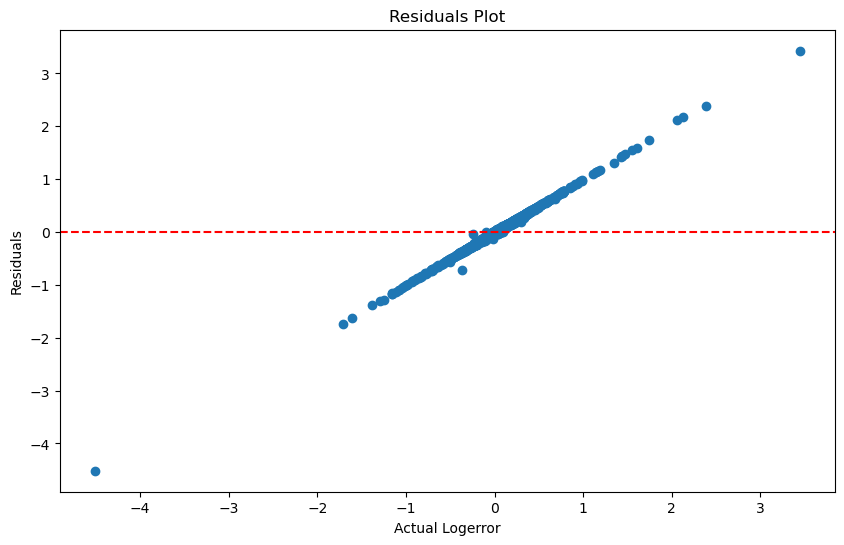

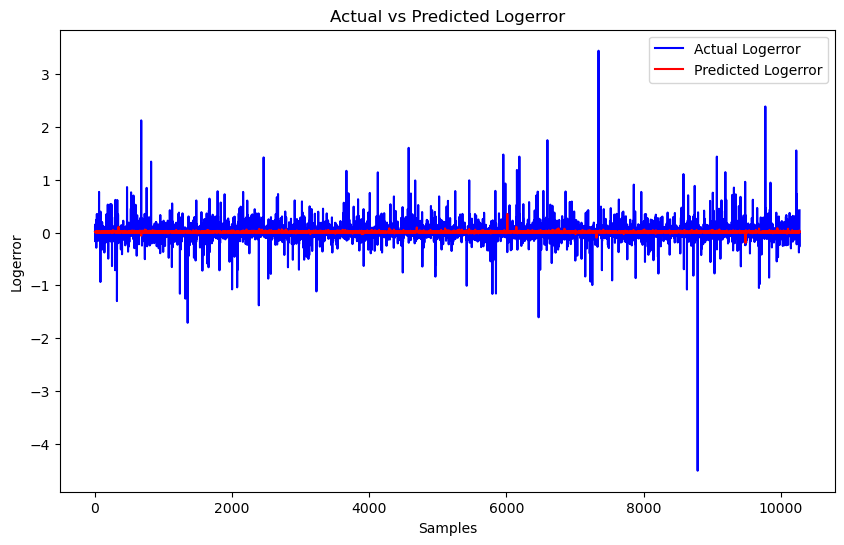

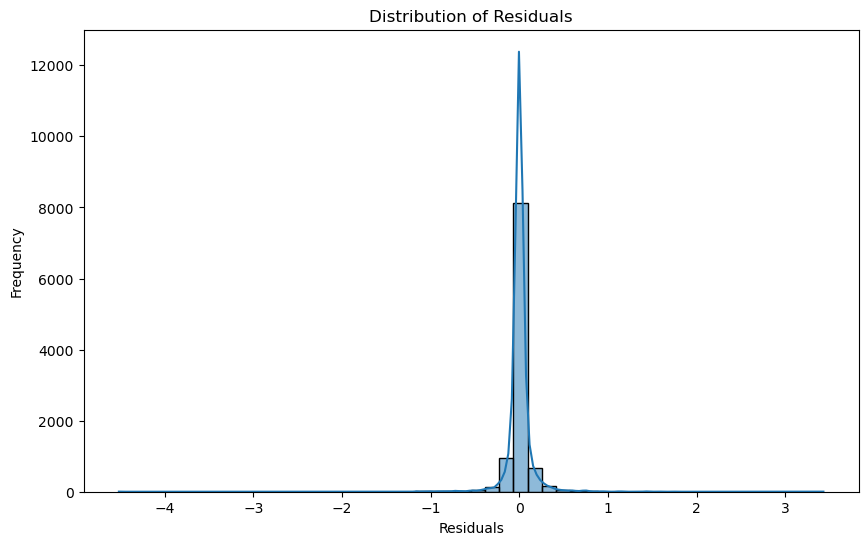

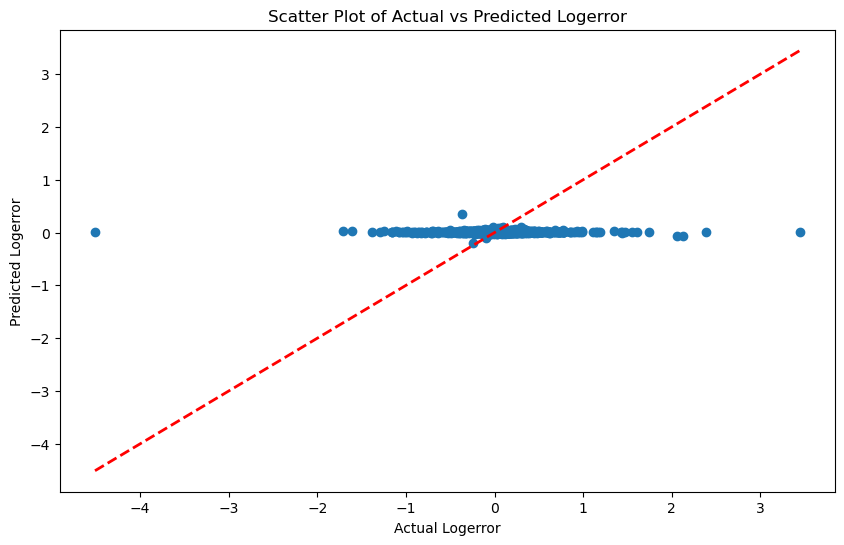

In [9]:
# Plot the residuals
residuals = valid_y_split - yhat.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(valid_y_split, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Logerror')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.plot(valid_y_split, label='Actual Logerror', color='blue')
plt.plot(yhat, label='Predicted Logerror', color='red')
plt.xlabel('Samples')
plt.ylabel('Logerror')
plt.title('Actual vs Predicted Logerror')
plt.legend()
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(valid_y_split, yhat.flatten())
plt.plot([valid_y_split.min(), valid_y_split.max()], [valid_y_split.min(), valid_y_split.max()], 'r--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Scatter Plot of Actual vs Predicted Logerror')
plt.show()



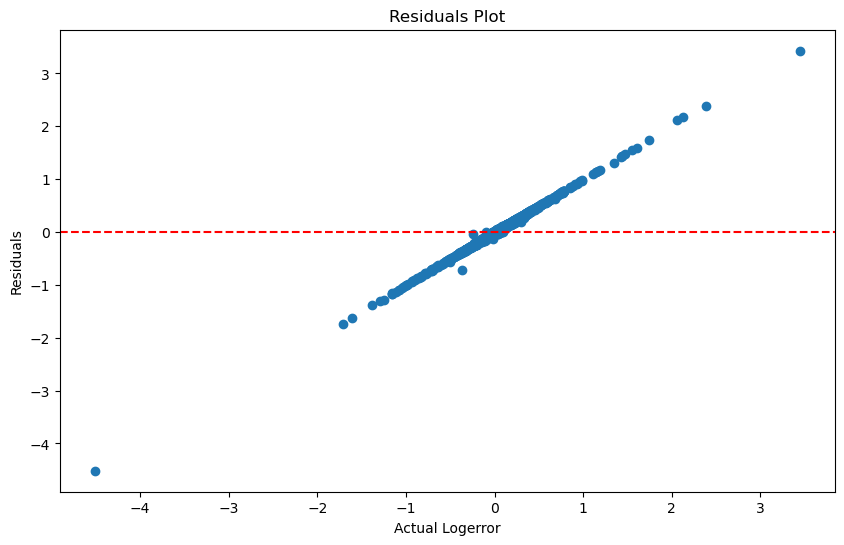

In [10]:
# Plot the residuals
residuals = valid_y_split - yhat.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(valid_y_split, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Logerror')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have your correlation matrix
corr_matrix = df_train.corr()  # Replace df with your DataFrame

# Create the heatmap with increased text size
plt.figure(figsize=(100, 80))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, 
             annot=True, 
             fmt='.2f', 
             cmap='coolwarm', 
             annot_kws={'size': 24},  # Increase text size here
             cbar_kws={'label': 'Correlation Coefficient'})
plt.xlabel('Features', fontsize=26)  # Adjust x-axis label size
plt.ylabel('Features', fontsize=26)  # Adjust y-axis label size

# Set tick label sizes for x and y axes
plt.xticks(fontsize=26)  # Increase x-axis tick label size
plt.yticks(fontsize=26)

plt.title('Correlation Matrix', fontsize=30)  # Increase title size if needed
plt.show()
